In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import glob

In [10]:
# Importing the necessary Libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Classification/first_trial_set.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/Classification")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
# Defining the path for the data library
import pathlib
data_dir = "/content/drive/MyDrive/Colab Notebooks/Classification/dataset/training_set"
data_dir = pathlib.Path(data_dir)

In [16]:
# Determining the image counts for all the images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8000


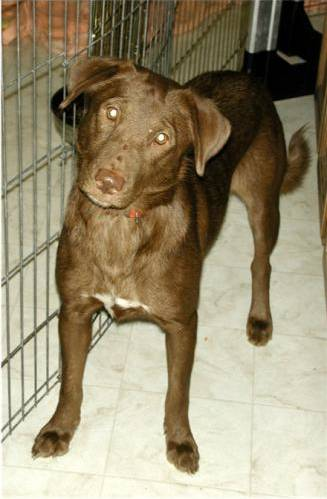

In [17]:
# Defining dogs images directory
dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[0]))

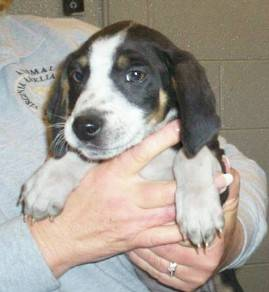

In [19]:
PIL.Image.open(str(dogs[1]))

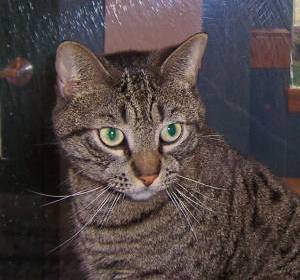

In [20]:
# Defining cats images directory
cats = list(data_dir.glob('cats/*'))
PIL.Image.open(str(cats[0]))

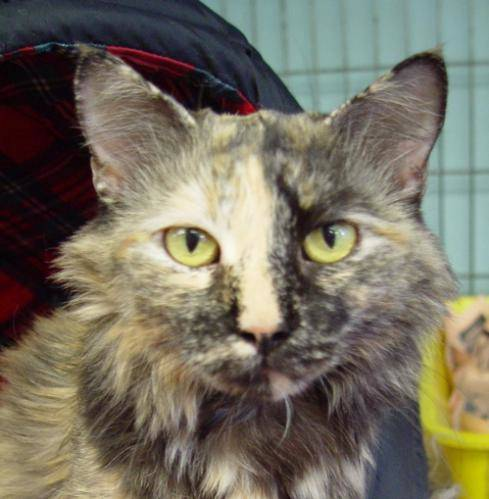

In [21]:
PIL.Image.open(str(cats[1]))

In [22]:
# Defining some parameters for the loaders
batch_size = 32
img_height = 180
img_width = 180

In [24]:
# Splitting the dataset into training data set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.


In [25]:
# Splitting the dataset into testing dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


#Visualization of Data Set

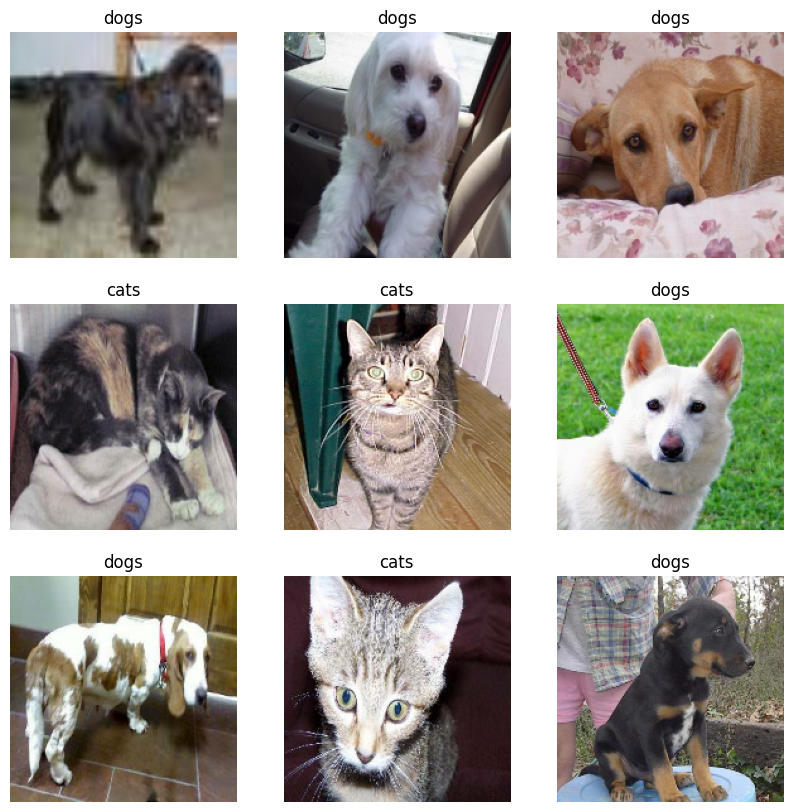

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [28]:
# Manually iterating and retrieving batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [29]:
# Configuring the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
# Standardizing the data
normalization_layer = layers.Rescaling(1./255)

In [31]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.05392133 0.96743643


In [32]:
# Creating the model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
# Summary of the model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [36]:
# Training the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
200/200 [==============================] - 241s 1s/step - loss: 0.5317 - accuracy: 0.7330 - val_loss: 0.5704 - val_accuracy: 0.7163
Epoch 2/10
200/200 [==============================] - 232s 1s/step - loss: 0.4516 - accuracy: 0.7914 - val_loss: 0.4940 - val_accuracy: 0.7606
Epoch 3/10
200/200 [==============================] - 234s 1s/step - loss: 0.3820 - accuracy: 0.8264 - val_loss: 0.4951 - val_accuracy: 0.7800
Epoch 4/10
200/200 [==============================] - 219s 1s/step - loss: 0.3074 - accuracy: 0.8700 - val_loss: 0.5450 - val_accuracy: 0.7606
Epoch 5/10
200/200 [==============================] - 224s 1s/step - loss: 0.2290 - accuracy: 0.9077 - val_loss: 0.5936 - val_accuracy: 0.7462
Epoch 6/10
200/200 [==============================] - 219s 1s/step - loss: 0.1538 - accuracy: 0.9414 - val_loss: 0.7631 - val_accuracy: 0.7569
Epoch 7/10
200/200 [==============================] - 218s 1s/step - loss: 0.1040 - accuracy: 0.9617 - val_loss: 0.7664 - val_accuracy: 0.7569

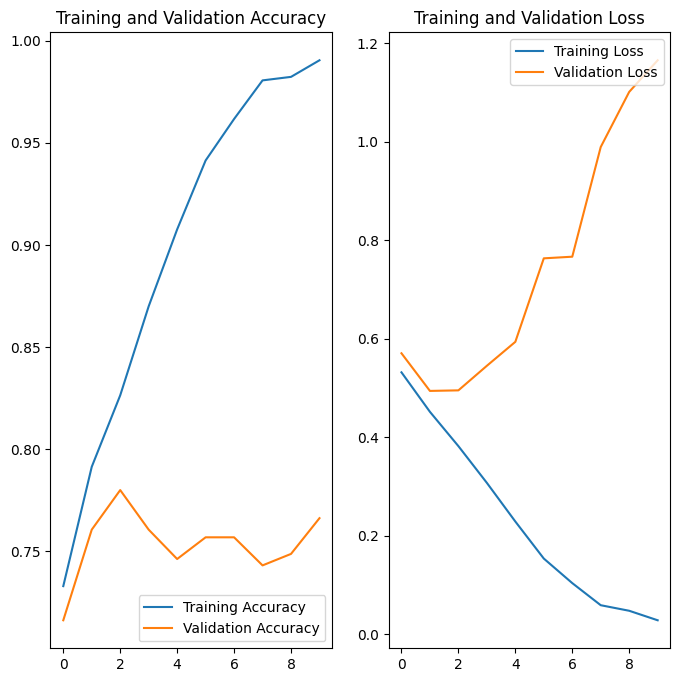

In [37]:
# Visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [38]:
# Data Augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

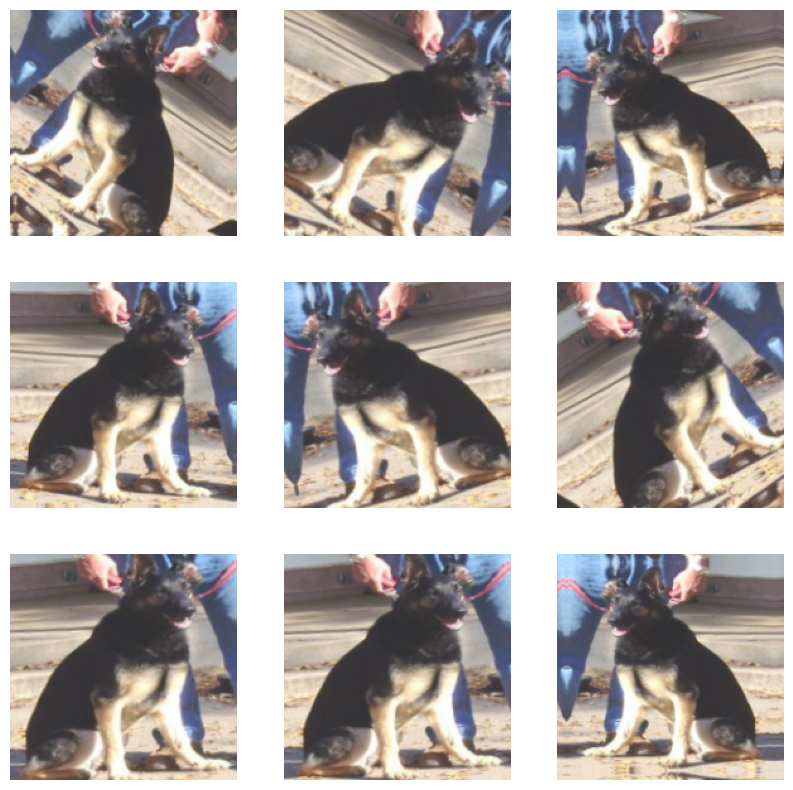

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [40]:
# Dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [43]:
# Compiling and training the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [45]:
epochs = 15
history = model.fit(train_ds, validation_data=val_ds,epochs=epochs)

Epoch 1/15
200/200 [==============================] - 252s 1s/step - loss: 0.6888 - accuracy: 0.5848 - val_loss: 0.7664 - val_accuracy: 0.5412
Epoch 2/15
200/200 [==============================] - 260s 1s/step - loss: 0.6113 - accuracy: 0.6664 - val_loss: 0.5825 - val_accuracy: 0.6969
Epoch 3/15
200/200 [==============================] - 260s 1s/step - loss: 0.5737 - accuracy: 0.6995 - val_loss: 0.5388 - val_accuracy: 0.7312
Epoch 4/15
200/200 [==============================] - 257s 1s/step - loss: 0.5366 - accuracy: 0.7277 - val_loss: 0.5409 - val_accuracy: 0.7194
Epoch 5/15
200/200 [==============================] - 259s 1s/step - loss: 0.5180 - accuracy: 0.7442 - val_loss: 0.5059 - val_accuracy: 0.7600
Epoch 6/15
200/200 [==============================] - 262s 1s/step - loss: 0.5012 - accuracy: 0.7548 - val_loss: 0.5055 - val_accuracy: 0.7606
Epoch 7/15
200/200 [==============================] - 253s 1s/step - loss: 0.4872 - accuracy: 0.7572 - val_loss: 0.4574 - val_accuracy: 0.7925

In [51]:
# Load and show an image in pillow
from PIL import Image
import os, os.path

imgs = []
path = "/content/drive/MyDrive/Colab Notebooks/Classification/both2.jpeg"
valid_images = [ ".jpg",".jpeg",".png"]

# Loading the image
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 62ms/step
This image most likely belongs to dogs with a 84.81 percent confidence.
